### This notebook demonstrates the basic workflow for training a machine learning model on the invasive species dataset and hyperspectral data. 

- Step 1: Load the data
- Step 2: Preprocess the data (extract spectral signatures)
- Step 3: Train the model
- Step 4: Evaluate the model
- Step 5: Make predictions
- Step 6: Visualize the results
- Step 7: Save the model
- Step 8: Load the model
- Step 9: Make predictions on new data
- Step 10: Visualize the results

In [1]:
import xarray as xr
import xvec
import matplotlib.pyplot as plt
import geopandas as gpd
from dask.diagnostics import ProgressBar

In [2]:
# Step 1 - Load the data

# Load hyperspectral data
# This is a cleaned version of the data, after removing the atmospheric contaminated regions.
ds = xr.open_zarr('/mnt/hdd1/fran/fran_sep2018_clean.zarr')
ds.rio.write_crs("EPSG:32734", inplace=True)
ds

<xarray.Dataset> Size: 65GB
Dimensions:      (wl: 202, x: 16310, y: 9885)
Coordinates:
  * wl           (wl) float64 2kB 0.4066 0.4134 0.4201 ... 1.983 1.989 1.996
  * x            (x) float64 130kB 3.14e+05 3.14e+05 ... 3.629e+05 3.629e+05
  * y            (y) float64 79kB 6.266e+06 6.266e+06 ... 6.237e+06 6.237e+06
    spatial_ref  int64 8B 0
Data variables:
    reflectance  (wl, x, y) int16 65GB dask.array<chunksize=(202, 10, 1000), meta=np.ndarray>

In [7]:
# Load invasive species point data
# gdf = gpd.read_file('/home/geethen/invasives/hypinvalimap/data/aliens_sep2018.shp')
gdf = gpd.read_file('/home/geethen/invasives/hypinvalimap/data/aliens_sep2018_bioscape2023.shp')
gdf = gdf.to_crs("EPSG:32734")
# Drop rows where change == 1 and 2023_class is None or NaN
gdf = gdf[~((gdf['change'] == 1) & (gdf['2023_class'].isna()))]
gdf.head()
gdf.isna().sum()

fid              0
class            0
group            0
layer           73
path            74
2018_2023      577
change           0
notes         1430
2023_class    1393
geometry         0
dtype: int64

In [4]:
gdf.crs

<Projected CRS: EPSG:32734>
Name: WGS 84 / UTM zone 34S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°E and 24°E, southern hemisphere between 80°S and equator, onshore and offshore. Angola. Botswana. Democratic Republic of the Congo (Zaire). Namibia. South Africa. Zambia.
- bounds: (18.0, -80.0, 24.0, 0.0)
Coordinate Operation:
- name: UTM zone 34S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
print(ds.rio.crs)

EPSG:32734


In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import random
import numpy as np
import leafmap.foliumap as leafmap
from pyproj import Transformer
import folium
import geopandas as gpd

def plot_spectral_and_map(ds, gdf=None, crs_from='EPSG:32610', crs_to='EPSG:4326'):
    """
    Plot points on a map with the extent of `ds` using a bounding box and optionally visualize a GeoDataFrame.

    Parameters:
    ds: xarray Dataset containing spectral data
    gdf: GeoDataFrame to visualize on the map, colored by the 'class' column
    crs_from: The CRS of your input coordinates (default UTM Zone 10N)
    crs_to: The target CRS (default WGS84)
    """
    # Convert coordinates to lat/lon
    transformer = Transformer.from_crs(crs_from, crs_to, always_xy=True)
    
    # Create leafmap
    m = leafmap.Map(
        zoom=15,
        draw_control=False,
        measure_control=False,
        fullscreen_control=False,
        basemap='Esri.WorldImagery'
    )
    
    # Add satellite basemap
    m.add_basemap('SATELLITE')
    m.add_basemap('Esri.WorldImagery')
    m.add_basemap('ESA WorldCover 2021')
    
    # Add a bounding box around the dataset in red
    x_min, x_max = ds.x.min(), ds.x.max()
    y_min, y_max = ds.y.min(), ds.y.max()

    # Convert bounding box corners to lat/lon
    lon_min, lat_min = transformer.transform(x_min, y_min)
    lon_max, lat_max = transformer.transform(x_max, y_max)

    # Create a rectangle for the bounding box
    folium.Rectangle(
        bounds=[[lat_min, lon_min], [lat_max, lon_max]],
        color='red',
        weight=1,
        fill=False
    ).add_to(m)
    
    # If a GeoDataFrame is provided
    if gdf is not None:
        # Ensure the GeoDataFrame is in the target CRS
        if gdf.crs != crs_to:
            gdf = gdf.to_crs(crs_to)
        
        # Generate unique colors for each class
        classes = gdf['class'].unique()
        colors = {cls: f"#{random.randint(0, 0xFFFFFF):06x}" for cls in classes}
        
        # Add points to the map
        for _, row in gdf.iterrows():
            point_coords = row.geometry.coords[0]
            folium.CircleMarker(
                location=(point_coords[1], point_coords[0]),
                radius=5,
                color=colors[row['class']],
                fill=True,
                fill_color=colors[row['class']],
                fill_opacity=0.7,
                popup=f"Class: {row['class']}"
            ).add_to(m)
        
        # Center map on the centroid of the GeoDataFrame's bounding box
        bbox_centroid = gdf.geometry.unary_union.centroid
        m.set_center(bbox_centroid.x, bbox_centroid.y, zoom=12)
    
    # Display both plots
    plt.tight_layout()
    plt.show()
    display(m)

# Example usage:
plot_spectral_and_map(ds, gdf=gdf, crs_from='EPSG:32734')#'EPSG:22234'


<Figure size 640x480 with 0 Axes>

### Step 2: Preprocess data (extract spectral signatures at points)

In [8]:
def extract_points(ds, points):
    """
    Extracts data values at specified points from a locally stored dataset.

    Parameters:
    - ds: str, path to the dataset (e.g., netCDF or GeoTIFF).
    - points: GeoDataFrame, point locations to extract data.

    Returns:
    - DataFrame containing extracted data values and point indices.
    """
    # Extract data at points
    extracted = ds.xvec.extract_points(
        points['geometry'], 
        x_coords="x", 
        y_coords="y", 
        index=True
    )
    
    return extracted

df = extract_points(ds, gdf)
df.head()

<xarray.Dataset> Size: 178B
Dimensions:      (wl: 5, geometry: 5)
Coordinates:
  * wl           (wl) float64 40B 0.4066 0.4134 0.4201 0.4269 0.4337
    spatial_ref  int64 8B 0
  * geometry     (geometry) object 40B POINT (330491.9212860309 6236818.61587...
    index        (geometry) int64 40B 0 1 2 3 4
Data variables:
    reflectance  (wl, geometry) int16 50B dask.array<chunksize=(5, 5), meta=np.ndarray>
Indexes:
    geometry  GeometryIndex (crs=EPSG:32734)

In [69]:
df.reflectance.data.compute()[:,500]

array([2092, 2503, 2566, 2781, 2889, 2957, 2945, 2901, 2851, 2845, 2868,
       2882, 2882, 2850, 2823, 2845, 2846, 2850, 2853, 2852, 2843, 2849,
       2845, 2861, 2874, 2891, 2895, 2897, 2894, 2911, 2918, 2920, 2912,
       2907, 2904, 2889, 2881, 2897, 2893, 2888, 2893, 2914, 2956, 2992,
       3005, 3028, 3047, 3064, 3084, 3101, 3111, 3109, 3100, 3085, 3072,
       3062, 3058, 3062, 3069, 3072, 3075, 3075, 3092, 3086, 3061, 3042,
       3018, 2987, 2954, 2881, 2810, 2747, 2688, 2651, 2625, 2587, 2550,
       2513, 2476, 2439, 2401, 2366, 2337, 2311, 2284, 2253, 2219, 2192,
       2158, 2120, 2086, 2070, 2085, 2128, 2180, 2243, 2314, 2390, 2452,
       2492, 2499, 2471, 2422, 2358, 2290, 2229, 2164, 2099, 2034, 1965,
       1895, 1828, 1762, 1696, 1632, 1568, 1506, 1439, 1377, 1327, 1294,
       1274, 1262, 1254, 1252, 1255, 1259, 1273, 1276, 1278, 1280, 1286,
       1294, 1295, 1280, 1257, 1235, 1208, 1172, 1136, 1097, 1059,  486,
        462,  441,  404,  374,  392,  450,  519,  5

In [9]:
df.reflectance.data.compute()[:,2]

array([ 969, 1142, 1242, 1370, 1465, 1529, 1558, 1549, 1536, 1573, 1617,
       1668, 1710, 1737, 1775, 1822, 1846, 1864, 1905, 1954, 2002, 2040,
       2079, 2118, 2156, 2197, 2248, 2303, 2353, 2397, 2448, 2494, 2532,
       2588, 2650, 2705, 2757, 2800, 2841, 2889, 2920, 2938, 2963, 2980,
       3003, 3034, 3066, 3104, 3141, 3178, 3215, 3255, 3297, 3341, 3383,
       3422, 3453, 3482, 3508, 3537, 3564, 3589, 3627, 3644, 3661, 3670,
       3676, 3687, 3720, 3738, 3758, 3755, 3753, 3761, 3781, 3791, 3801,
       3812, 3824, 3834, 3846, 3857, 3867, 3876, 3887, 3899, 3908, 3929,
       3946, 3949, 3953, 3967, 4001, 4053, 4094, 4117, 4138, 4155, 4172,
       4187, 4187, 4164, 4128, 4080, 4029, 3981, 3931, 3880, 3829, 3774,
       3720, 3666, 3613, 3562, 3511, 3470, 3399, 3360, 3385, 3462, 3553,
       3607, 3613, 3643, 3663, 3689, 3715, 3743, 3704, 3662, 3643, 3670,
       3709, 3719, 3663, 3610, 3533, 3449, 3363, 3279, 3188, 3086, 1414,
       1328, 1244, 1130, 1025,  967,  982, 1056, 11

  0%|          | 0/16 [00:00<?, ?it/s]

 38%|███▊      | 6/16 [00:27<00:45,  4.53s/it]

 50%|█████     | 8/16 [00:37<00:37,  4.64s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [01:10<00:00,  4.42s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [01:13<00:00,  4.62s/it]


In [10]:
widedf = df.xvec.to_geodataframe(long=True).pivot_table(
    index=['geometry'],  # Replace with your actual spatial and other relevant dimensions
    columns='wl',
    values='reflectance'
).reset_index()
widedf

wl,geometry,0.40661,0.41337,0.42013,0.42689,0.43367,0.44044,0.44723,0.45402,0.46082,...,1.77188,1.77812,1.78435,1.95847,1.96467,1.97087,1.97707,1.98326,1.98946,1.99566
0,POINT (316280.256 6236980.927),1.0,1.0,21.0,32.0,53.0,72.0,86.0,87.0,81.0,...,883.0,847.0,806.0,103.0,108.0,112.0,117.0,121.0,126.0,130.0
1,POINT (316082.743 6237043.539),1.0,1.0,1.0,1.0,3.0,4.0,7.0,7.0,4.0,...,232.0,219.0,211.0,43.0,39.0,36.0,33.0,30.0,27.0,25.0
2,POINT (316030.946 6237039.555),1.0,1.0,13.0,36.0,62.0,75.0,78.0,75.0,69.0,...,708.0,672.0,641.0,76.0,81.0,84.0,88.0,93.0,98.0,103.0
3,POINT (315412.606 6236374.853),0.0,0.0,0.0,3.0,6.0,4.0,3.0,2.0,3.0,...,0.0,0.0,0.0,2.0,3.0,4.0,4.0,5.0,5.0,6.0
4,POINT (315332.588 6236259.896),1.0,1.0,1.0,1.0,8.0,14.0,16.0,15.0,8.0,...,1.0,1.0,1.0,4.0,5.0,5.0,6.0,7.0,6.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,POINT (361244.137 6237382.359),147.0,251.0,263.0,320.0,346.0,372.0,379.0,374.0,369.0,...,1923.0,1896.0,1884.0,1293.0,1288.0,1284.0,1281.0,1278.0,1272.0,1267.0
1682,POINT (361128.79 6237480.826),206.0,292.0,337.0,409.0,464.0,510.0,543.0,565.0,569.0,...,2674.0,2670.0,2662.0,2062.0,2053.0,2046.0,2039.0,2031.0,2021.0,2013.0
1683,POINT (360889.654 6237504.506),1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,...,440.0,430.0,423.0,167.0,157.0,148.0,138.0,130.0,119.0,110.0
1684,POINT (360835.263 6237402.287),1.0,1.0,1.0,4.0,8.0,9.0,14.0,15.0,16.0,...,761.0,748.0,738.0,379.0,367.0,353.0,341.0,328.0,313.0,300.0


In [11]:
import geopandas as gpd

# Convert geometry to WKB for compact, lossless binary storage
widedf['geometry'] = widedf['geometry'].apply(lambda geom: geom.wkb)

# Save to Feather
widedf.to_feather("/home/geethen/invasives/hypinvalimap/data/2018_extracted_data.feather")


In [12]:
import pandas as pd 
import geopandas as gpd
# Read the Feather file
xdf = pd.read_feather("/home/geethen/invasives/hypinvalimap/data/2018_extracted_data.feather")

# Convert geometry back from WKB
from shapely import wkb
xdf['geometry'] = xdf['geometry'].apply(wkb.loads)

# Restore as a GeoDataFrame with correct CRS if needed
xdf = gpd.GeoDataFrame(xdf, geometry='geometry', crs="EPSG:4326")
xdf


wl,geometry,0.40661,0.41337,0.42013,0.42689,0.43367,0.44044,0.44723,0.45402,0.46082,...,1.77188,1.77812,1.78435,1.95847,1.96467,1.97087,1.97707,1.98326,1.98946,1.99566
0,POINT (316280.25632 6236980.92664),1.0,1.0,21.0,32.0,53.0,72.0,86.0,87.0,81.0,...,883.0,847.0,806.0,103.0,108.0,112.0,117.0,121.0,126.0,130.0
1,POINT (316082.74302 6237043.53892),1.0,1.0,1.0,1.0,3.0,4.0,7.0,7.0,4.0,...,232.0,219.0,211.0,43.0,39.0,36.0,33.0,30.0,27.0,25.0
2,POINT (316030.94558 6237039.55451),1.0,1.0,13.0,36.0,62.0,75.0,78.0,75.0,69.0,...,708.0,672.0,641.0,76.0,81.0,84.0,88.0,93.0,98.0,103.0
3,POINT (315412.60622 6236374.85252),0.0,0.0,0.0,3.0,6.0,4.0,3.0,2.0,3.0,...,0.0,0.0,0.0,2.0,3.0,4.0,4.0,5.0,5.0,6.0
4,POINT (315332.58755 6236259.89612),1.0,1.0,1.0,1.0,8.0,14.0,16.0,15.0,8.0,...,1.0,1.0,1.0,4.0,5.0,5.0,6.0,7.0,6.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,POINT (361244.13722 6237382.35901),147.0,251.0,263.0,320.0,346.0,372.0,379.0,374.0,369.0,...,1923.0,1896.0,1884.0,1293.0,1288.0,1284.0,1281.0,1278.0,1272.0,1267.0
1682,POINT (361128.78966 6237480.82644),206.0,292.0,337.0,409.0,464.0,510.0,543.0,565.0,569.0,...,2674.0,2670.0,2662.0,2062.0,2053.0,2046.0,2039.0,2031.0,2021.0,2013.0
1683,POINT (360889.65446 6237504.50552),1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,...,440.0,430.0,423.0,167.0,157.0,148.0,138.0,130.0,119.0,110.0
1684,POINT (360835.26293 6237402.28694),1.0,1.0,1.0,4.0,8.0,9.0,14.0,15.0,16.0,...,761.0,748.0,738.0,379.0,367.0,353.0,341.0,328.0,313.0,300.0


In [14]:
gdf_merged = gpd.sjoin(xdf, gdf[['geometry', 'class', 'group']], how='left', predicate='intersects')
gdf_merged

,geometry,0.40661,0.41337,0.42013,0.42689,0.43367,0.44044,0.44723,0.45402,0.46082,...,1.95847,1.96467,1.97087,1.97707,1.98326,1.98946,1.99566,index_right,class,group
0,POINT (316280.25632 6236980.92664),1.0,1.0,21.0,32.0,53.0,72.0,86.0,87.0,81.0,...,103.0,108.0,112.0,117.0,121.0,126.0,130.0,401,6,2
1,POINT (316082.74302 6237043.53892),1.0,1.0,1.0,1.0,3.0,4.0,7.0,7.0,4.0,...,43.0,39.0,36.0,33.0,30.0,27.0,25.0,402,6,2
2,POINT (316030.94558 6237039.55451),1.0,1.0,13.0,36.0,62.0,75.0,78.0,75.0,69.0,...,76.0,81.0,84.0,88.0,93.0,98.0,103.0,400,6,2
3,POINT (315412.60622 6236374.85252),0.0,0.0,0.0,3.0,6.0,4.0,3.0,2.0,3.0,...,2.0,3.0,4.0,4.0,5.0,5.0,6.0,1356,6,1
4,POINT (315332.58755 6236259.89612),1.0,1.0,1.0,1.0,8.0,14.0,16.0,15.0,8.0,...,4.0,5.0,5.0,6.0,7.0,6.0,7.0,1355,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,POINT (361244.13722 6237382.35901),147.0,251.0,263.0,320.0,346.0,372.0,379.0,374.0,369.0,...,1293.0,1288.0,1284.0,1281.0,1278.0,1272.0,1267.0,228,7,2
1682,POINT (361128.78966 6237480.82644),206.0,292.0,337.0,409.0,464.0,510.0,543.0,565.0,569.0,...,2062.0,2053.0,2046.0,2039.0,2031.0,2021.0,2013.0,230,7,2
1683,POINT (360889.65446 6237504.50552),1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,...,167.0,157.0,148.0,138.0,130.0,119.0,110.0,224,3,2
1684,POINT (360835.26293 6237402.28694),1.0,1.0,1.0,4.0,8.0,9.0,14.0,15.0,16.0,...,379.0,367.0,353.0,341.0,328.0,313.0,300.0,225,3,2


# Build ML models

In [32]:
! uv pip install tabpfn -q
! uv pip install "tabpfn-extensions[all] @ git+https://github.com/PriorLabs/tabpfn-extensions.git" -q
! uv pip install cartopy geoviews datashader jupyter_bokeh -q

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = gdf_merged[gdf_merged.columns.drop(['geometry', 'class', 'group', 'index_right']).to_list()], gdf_merged['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [16]:
prediction_probabilities = clf.predict_proba(X_test)
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.68


In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = gdf_merged[gdf_merged.columns.drop(['geometry', 'class', 'group', 'index_right']).to_list()], gdf_merged['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [18]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

100%|██████████| 16/16 [00:31<00:00,  1.98s/it]

Accuracy 0.8185053380782918


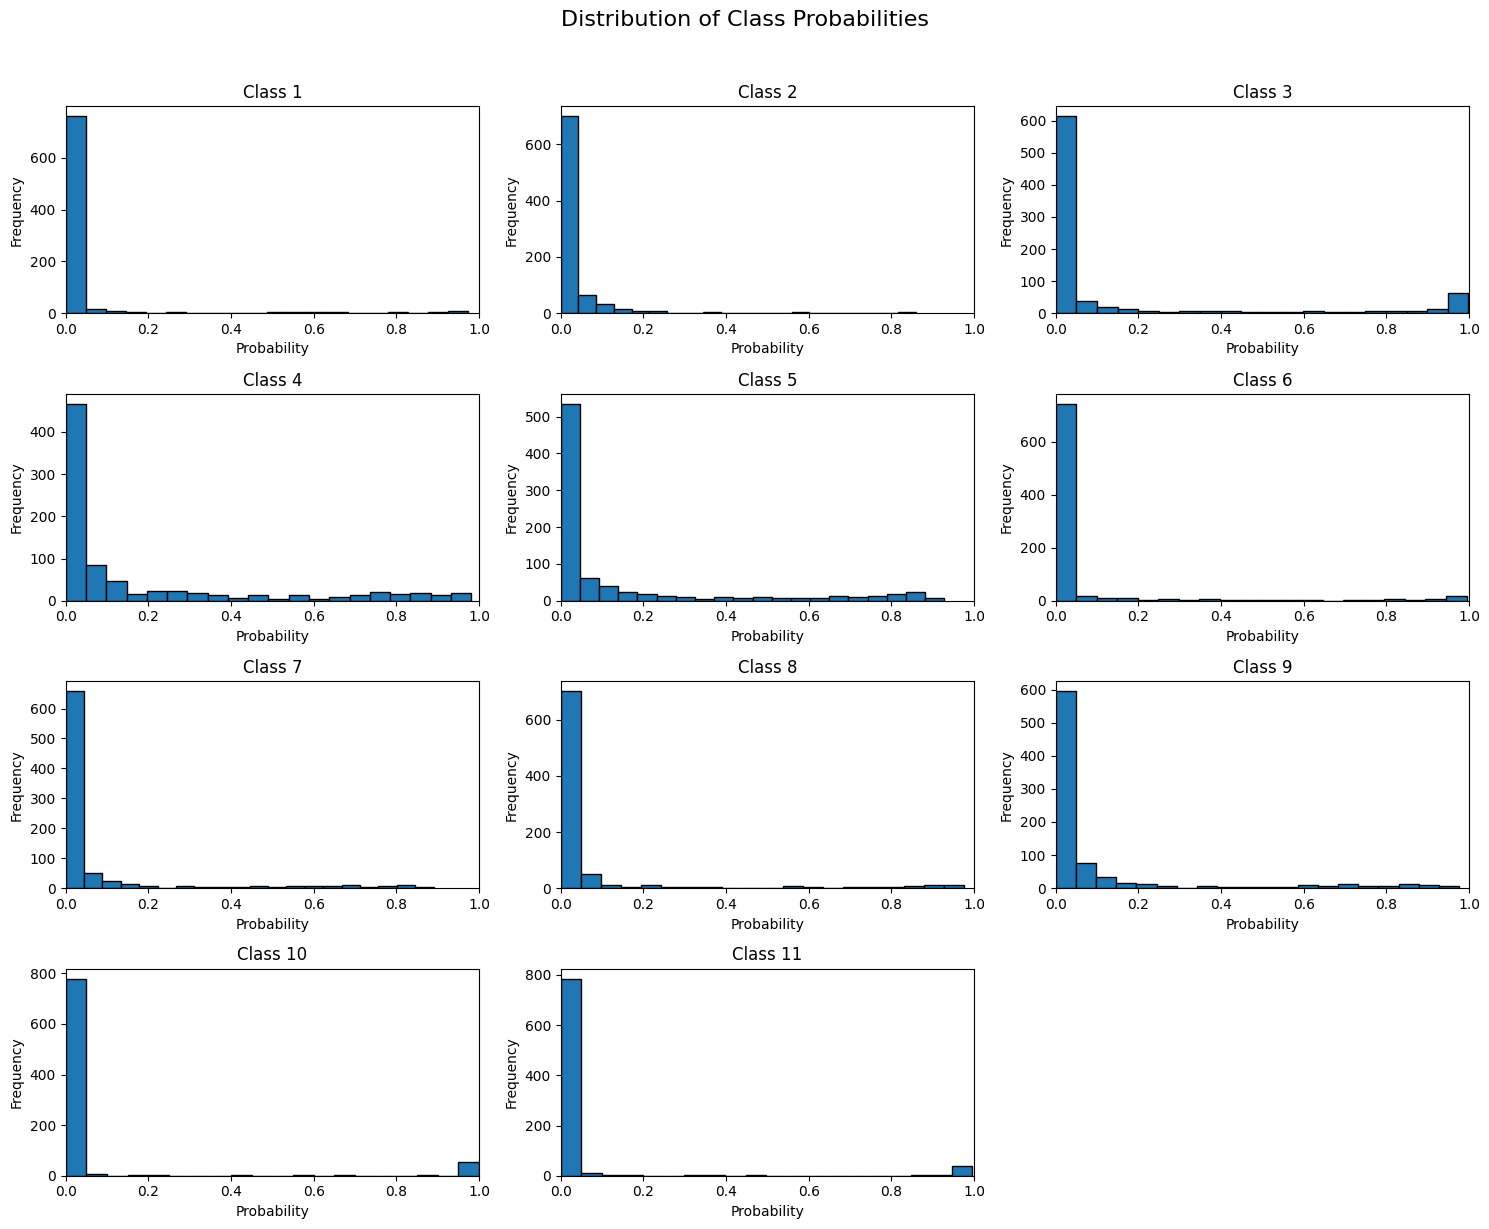

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming prediction_probabilities is your array of shape (844, 11)
# If it's not already a numpy array, you might need to convert it:
# prediction_probabilities = np.array(prediction_probabilities)

n_samples, n_classes = prediction_probabilities.shape

# Determine grid size for subplots (e.g., 4 rows, 3 columns for 11 classes)
n_cols = 3
n_rows = (n_classes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i in range(n_classes):
    ax = axes[i]
    ax.hist(prediction_probabilities[:, i], bins=20, edgecolor='black')
    ax.set_title(f'Class {i+1}')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, 1) # Probabilities are between 0 and 1

# Hide any unused subplots
for j in range(n_classes, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Distribution of Class Probabilities', y=1.02, fontsize=16) # Add a main title
plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()


# inference

In [19]:
def predict_on_chunk(chunk, model):
    probabilities = model.predict_proba(chunk)
    return probabilities

In [20]:
ds

<xarray.Dataset> Size: 65GB
Dimensions:      (wl: 202, x: 16310, y: 9885)
Coordinates:
  * wl           (wl) float64 2kB 0.4066 0.4134 0.4201 ... 1.983 1.989 1.996
  * x            (x) float64 130kB 3.14e+05 3.14e+05 ... 3.629e+05 3.629e+05
  * y            (y) float64 79kB 6.266e+06 6.266e+06 ... 6.237e+06 6.237e+06
    spatial_ref  int64 8B 0
Data variables:
    reflectance  (wl, x, y) int16 65GB dask.array<chunksize=(202, 10, 1000), meta=np.ndarray>

In [21]:
#part 3 - apply the model over chunks
result = xr.apply_ufunc(
    predict_on_chunk,
    ds.isel(x=slice(0, 30), y=slice(0, 30)).stack(sample=('x','y'))['reflectance'],
    input_core_dims=[['wl']],#input dim with features
    output_core_dims=[['class']],  # name for the new output dim
    exclude_dims=set(('wl',)),  #dims to drop in result
    output_sizes={'class': 11}, #length of the new dimension
    output_dtypes=[np.float32],
    dask="parallelized",
    kwargs={'model': clf}
)
result.compute()

<xarray.DataArray 'reflectance' (sample: 900, class: 11)> Size: 79kB
array([[0.78090332, 0.01563795, 0.01301646, ..., 0.02792847, 0.03376412,
        0.01687678],
       [0.34946158, 0.0525768 , 0.13212222, ..., 0.07660594, 0.01666237,
        0.02464994],
       [0.08642416, 0.02267249, 0.31279916, ..., 0.04412629, 0.00936383,
        0.04928901],
       ...,
       [0.05198604, 0.15596249, 0.00327282, ..., 0.65643827, 0.00209331,
        0.02521803],
       [0.05190599, 0.16839683, 0.00523379, ..., 0.59224448, 0.00314071,
        0.02909539],
       [0.05357712, 0.16912621, 0.00629597, ..., 0.57065517, 0.00384402,
        0.03158736]], shape=(900, 11))
Coordinates:
    spatial_ref  int64 8B 0
  * sample       (sample) object 7kB MultiIndex
  * x            (sample) float64 7kB 3.14e+05 3.14e+05 ... 3.141e+05 3.141e+05
  * y            (sample) float64 7kB 6.266e+06 6.266e+06 ... 6.266e+06
Dimensions without coordinates: class

In [22]:
#part 4 - post-processing
# result = result.where((result >= 0) & (result <= 1), np.nan) #valid values
result = result.unstack('sample') #remove the stack
result = result.rio.set_spatial_dims(x_dim='x',y_dim='y') #set the spatial dims
result = result.rio.write_crs("EPSG:32734") #set the CRS
# result = result.rio.clip(geometries).where(condition) #clip to the protected areas and no data
result = result.transpose('class', 'y', 'x') #transpose the data rio expects it this way
   

In [25]:
import hvplot.xarray
import holoviews as hv

test = result.rio.reproject("EPSG:4326",nodata=np.nan)
h = test.isel({'class':10}).hvplot(tiles=hv.element.tiles.EsriImagery(), 
                              project=True,rasterize=True,clim=(0,1),
                              cmap='magma',frame_width=400,data_aspect=1,alpha=0.5)
h

BokehModel(combine_events=True, render_bundle={'docs_json': {'9a84efc1-2580-4508-aa89-69891aaaf80a': {'version…

In [ ]:
def predict_xr(file,geometries):

    #part 1 - opening file
    #open the file
    print(f'file: {file}')
    ds = xr.open_dataset(file, engine='kerchunk', chunks='auto')

    #condition to use for masking no data later
    condition = (ds['reflectance'] > -1).any(dim='wavelength')

    #stack the data into a single dimension. This will be important for applying the model later
    ds = ds.stack(sample=('x','y'))
    
    #part 2 - pre-processing
    #remove bad wavelenghts
    wavelengths_to_drop = ds.wavelength.where(
        (ds.wavelength < 450) |
        (ds.wavelength >= 1340) & (ds.wavelength <= 1480) |
        (ds.wavelength >= 1800) & (ds.wavelength <= 1980) |
        (ds.wavelength > 2400), drop=True
    )
    # Use drop_sel() to remove those specific wavelength ranges
    ds = ds.drop_sel(wavelength=wavelengths_to_drop)
    
    #normalise the data
    l2_norm = np.sqrt((ds['reflectance'] ** 2).sum(dim='wavelength'))
    ds['reflectance'] = ds['reflectance'] / l2_norm
    
    #part 3 - apply the model over chunks
    result = xr.apply_ufunc(
        predict_on_chunk,
        ds['reflectance'],
        input_core_dims=[['wavelength']],#input dim with features
        output_core_dims=[['class']],  # name for the new output dim
        exclude_dims=set(('wavelength',)),  #dims to drop in result
        output_sizes={'class': 9}, #length of the new dimension
        output_dtypes=[np.float32],
        dask="parallelized",
        kwargs={'model': best_model}
    )

    #part 4 - post-processing
    result = result.where((result >= 0) & (result <= 1), np.nan) #valid values
    result = result.unstack('sample') #remove the stack
    result = result.rio.set_spatial_dims(x_dim='x',y_dim='y') #set the spatial dims
    result = result.rio.write_crs("EPSG:32734") #set the CRS
    result = result.rio.clip(geometries).where(condition) #clip to the protected areas and no data
    result = result.transpose('class', 'y', 'x') #transpose the data rio expects it this way
    return result